# Import Libraries

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.neurons.population import Ensemble
from src.network.network import Network
from src.network.connection import Connection

np.random.seed(42)

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 2

# Neural Communication Channel

## Test basic info transfer between two ensembles: A -> B

Running simulation with input = 0.5...


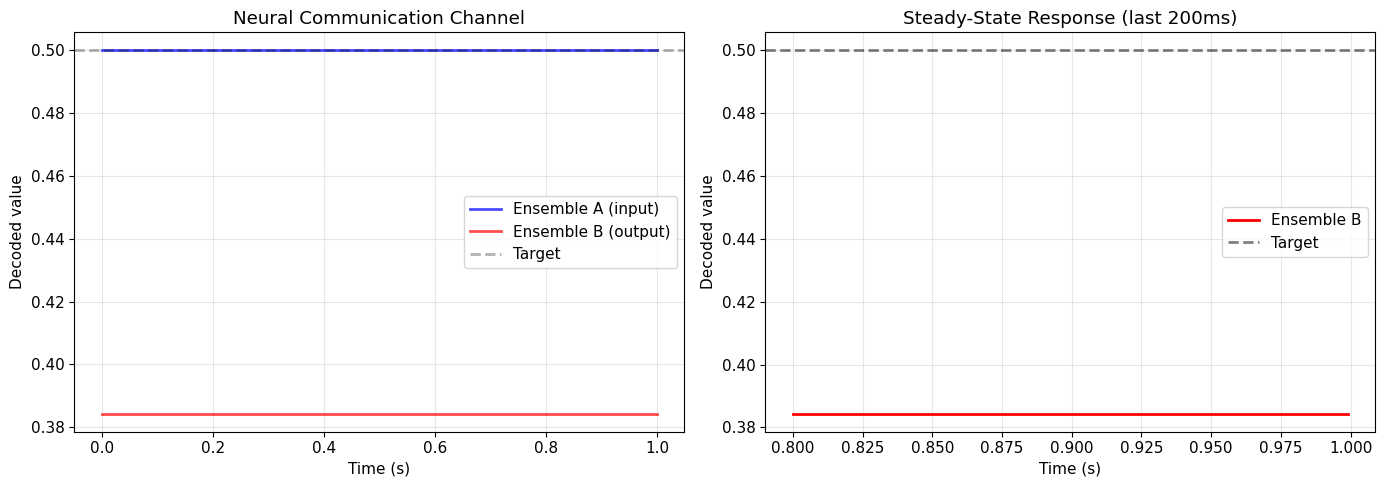


Target: 0.500
Final output: 0.384
Error: 0.116
Percent error: 23.1%


In [3]:
# Parameters to experiment with
N_NEURONS = 200  # Number of neurons per ensemble
INPUT_VALUE = 0.5  # Input to ensemble A
DURATION = 1.0  # Simulation duration (seconds)

# Create ensembles
ens_a = Ensemble(n_neurons=N_NEURONS, dimensions=1, seed=42)
ens_b = Ensemble(n_neurons=N_NEURONS, dimensions=1, seed=43)
ens_b.compute_decoders(n_samples=1000, noise_sigma=0.05)

# Create network
net = Network(dt=0.001)
net.add_ensemble(ens_a)
net.add_ensemble(ens_b)

# Connect A -> B
conn = Connection(ens_a, ens_b)
net.add_connection(conn)

# Compute decoders for ens_a (for probing)
ens_a.compute_decoders(n_samples=1000, noise_sigma=0.05)

# Add probes
net.probe(ens_a, 'ens_a', 'decoded')
net.probe(ens_b, 'ens_b', 'decoded')

# Set input to ensemble A
ens_a.set_input(np.array([INPUT_VALUE]))

# Run simulation
print(f"Running simulation with input = {INPUT_VALUE}...")
net.run(duration=DURATION)

# Get results
data_a = net.get_probe_data('ens_a')
data_b = net.get_probe_data('ens_b')
times = np.arange(len(data_a)) * net.dt

# Plot
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(times, data_a, label='Ensemble A (input)', alpha=0.7, color='blue')
plt.plot(times, data_b, label='Ensemble B (output)', alpha=0.7, color='red')
plt.axhline(INPUT_VALUE, color='k', linestyle='--', label='Target', alpha=0.3)
plt.xlabel('Time (s)')
plt.ylabel('Decoded value')
plt.title('Neural Communication Channel')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(times[-200:], data_b[-200:], label='Ensemble B', color='red', linewidth=2)
plt.axhline(INPUT_VALUE, color='k', linestyle='--', label='Target', alpha=0.5)
plt.xlabel('Time (s)')
plt.ylabel('Decoded value')
plt.title('Steady-State Response (last 200ms)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute error
final_output = data_b[-100:].mean()
error = abs(final_output - INPUT_VALUE)
print(f"\nTarget: {INPUT_VALUE:.3f}")
print(f"Final output: {final_output:.3f}")
print(f"Error: {error:.3f}")
print(f"Percent error: {100*error/abs(INPUT_VALUE):.1f}%")

## Vary Input Values

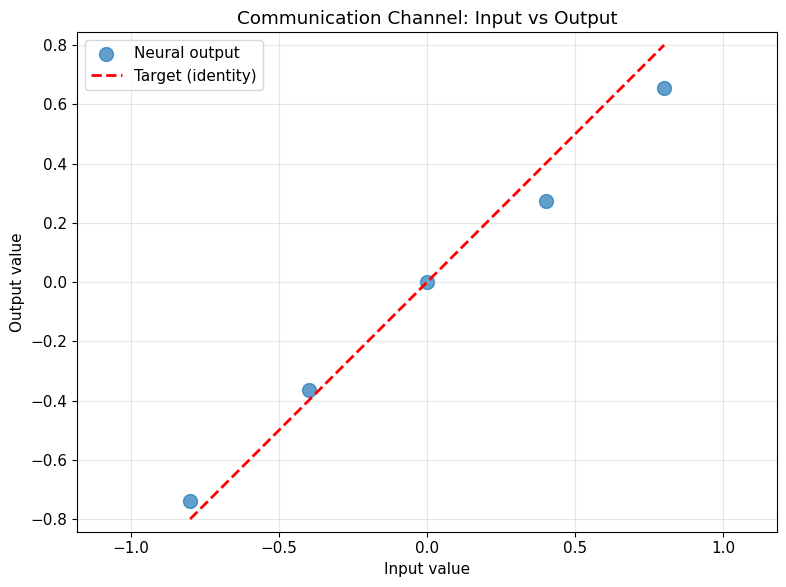


Communication Channel Results:
Input	Output	Error
-0.80	-0.738	0.062
-0.40	-0.365	0.035
 0.00	0.000	0.000
 0.40	0.274	0.126
 0.80	0.655	0.145


In [4]:
# Test multiple input values
test_inputs = [-0.8, -0.4, 0.0, 0.4, 0.8]
results = []

for input_val in test_inputs:
    # Create fresh ensembles
    ens_a = Ensemble(n_neurons=200, dimensions=1, seed=42)
    ens_b = Ensemble(n_neurons=200, dimensions=1, seed=43)
    ens_b.compute_decoders(n_samples=1000, noise_sigma=0.05)
    
    # Network
    net = Network(dt=0.001)
    net.add_ensemble(ens_a)
    net.add_ensemble(ens_b)
    conn = Connection(ens_a, ens_b)
    net.add_connection(conn)
    
    net.probe(ens_b, 'output', 'decoded')
    
    # Set input and run
    ens_a.set_input(np.array([input_val]))
    net.run(duration=0.5)
    
    # Get result
    data = net.get_probe_data('output')
    final = data[-100:].mean()
    results.append((input_val, final))

# Plot
inputs = [r[0] for r in results]
outputs = [r[1] for r in results]

plt.figure(figsize=(8, 6))
plt.scatter(inputs, outputs, s=100, alpha=0.7, label='Neural output')
plt.plot(inputs, inputs, 'r--', linewidth=2, label='Target (identity)')
plt.xlabel('Input value')
plt.ylabel('Output value')
plt.title('Communication Channel: Input vs Output')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print results
print("\nCommunication Channel Results:")
print("Input\tOutput\tError")
for inp, outp in results:
    print(f"{inp:5.2f}\t{outp:5.3f}\t{abs(outp-inp):.3f}")

# Neural Function Computation

## Compute Non-Linear Function: x^2

Input: -0.80, Output: 0.579, Target: 0.640, Error: 0.061
Input: -0.60, Output: 0.297, Target: 0.360, Error: 0.063
Input: -0.40, Output: 0.098, Target: 0.160, Error: 0.062
Input: -0.20, Output: 0.008, Target: 0.040, Error: 0.032
Input:  0.00, Output: 0.000, Target: 0.000, Error: 0.000
Input:  0.20, Output: 0.008, Target: 0.040, Error: 0.032
Input:  0.40, Output: 0.098, Target: 0.160, Error: 0.062
Input:  0.60, Output: 0.297, Target: 0.360, Error: 0.063
Input:  0.80, Output: 0.579, Target: 0.640, Error: 0.061


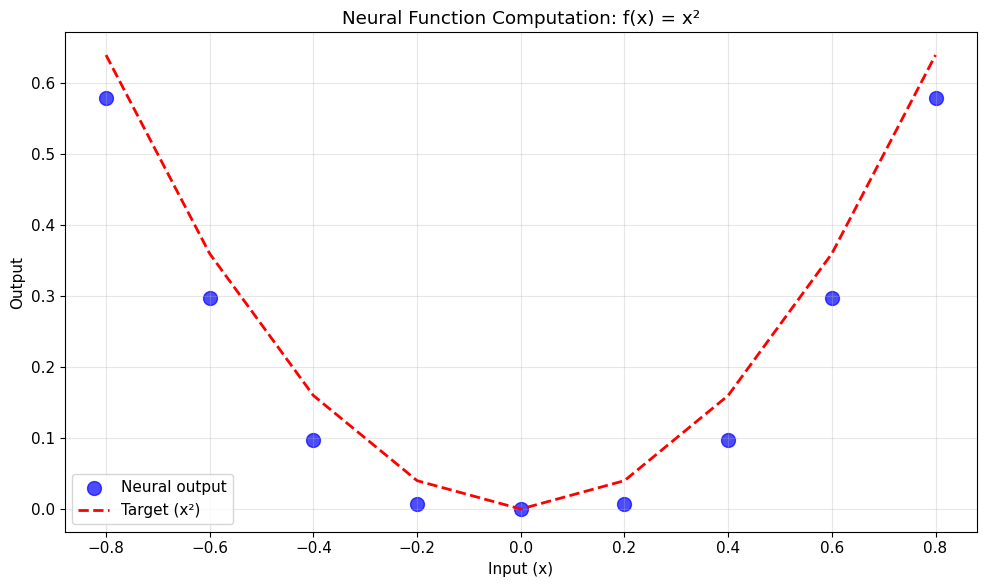


Mean error: 0.048
Max error: 0.063


In [5]:
# Parameters
N_NEURONS = 300
TEST_VALUES = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
FUNCTION = lambda x: x**2  # Change this to test other functions!

results = []

for val in TEST_VALUES:
    # Create ensembles
    ens_a = Ensemble(n_neurons=N_NEURONS, dimensions=1, seed=42)
    ens_b = Ensemble(n_neurons=N_NEURONS, dimensions=1, seed=43)
    ens_b.compute_decoders(n_samples=1000, noise_sigma=0.05)
    
    # Network
    net = Network(dt=0.001)
    net.add_ensemble(ens_a)
    net.add_ensemble(ens_b)
    
    # Connect with function
    conn = Connection(ens_a, ens_b, function=FUNCTION)
    net.add_connection(conn)
    
    # Probe
    net.probe(ens_b, 'output', 'decoded')
    
    # Set input and run
    ens_a.set_input(np.array([val]))
    net.run(duration=1.0)
    
    # Get result
    data = net.get_probe_data('output')
    final_output = data[-100:].mean()
    target = FUNCTION(val)
    
    results.append((val, final_output, target))
    print(f"Input: {val:5.2f}, Output: {final_output:5.3f}, Target: {target:5.3f}, Error: {abs(final_output - target):.3f}")

# Plot
inputs = [r[0] for r in results]
outputs = [r[1] for r in results]
targets = [r[2] for r in results]

plt.figure(figsize=(10, 6))
plt.scatter(inputs, outputs, label='Neural output', s=100, alpha=0.7, color='blue')
plt.plot(inputs, targets, 'r--', label='Target (x²)', linewidth=2)
plt.xlabel('Input (x)')
plt.ylabel('Output')
plt.title('Neural Function Computation: f(x) = x²')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Error analysis
errors = [abs(r[1] - r[2]) for r in results]
print(f"\nMean error: {np.mean(errors):.3f}")
print(f"Max error: {np.max(errors):.3f}")

## Other Functions

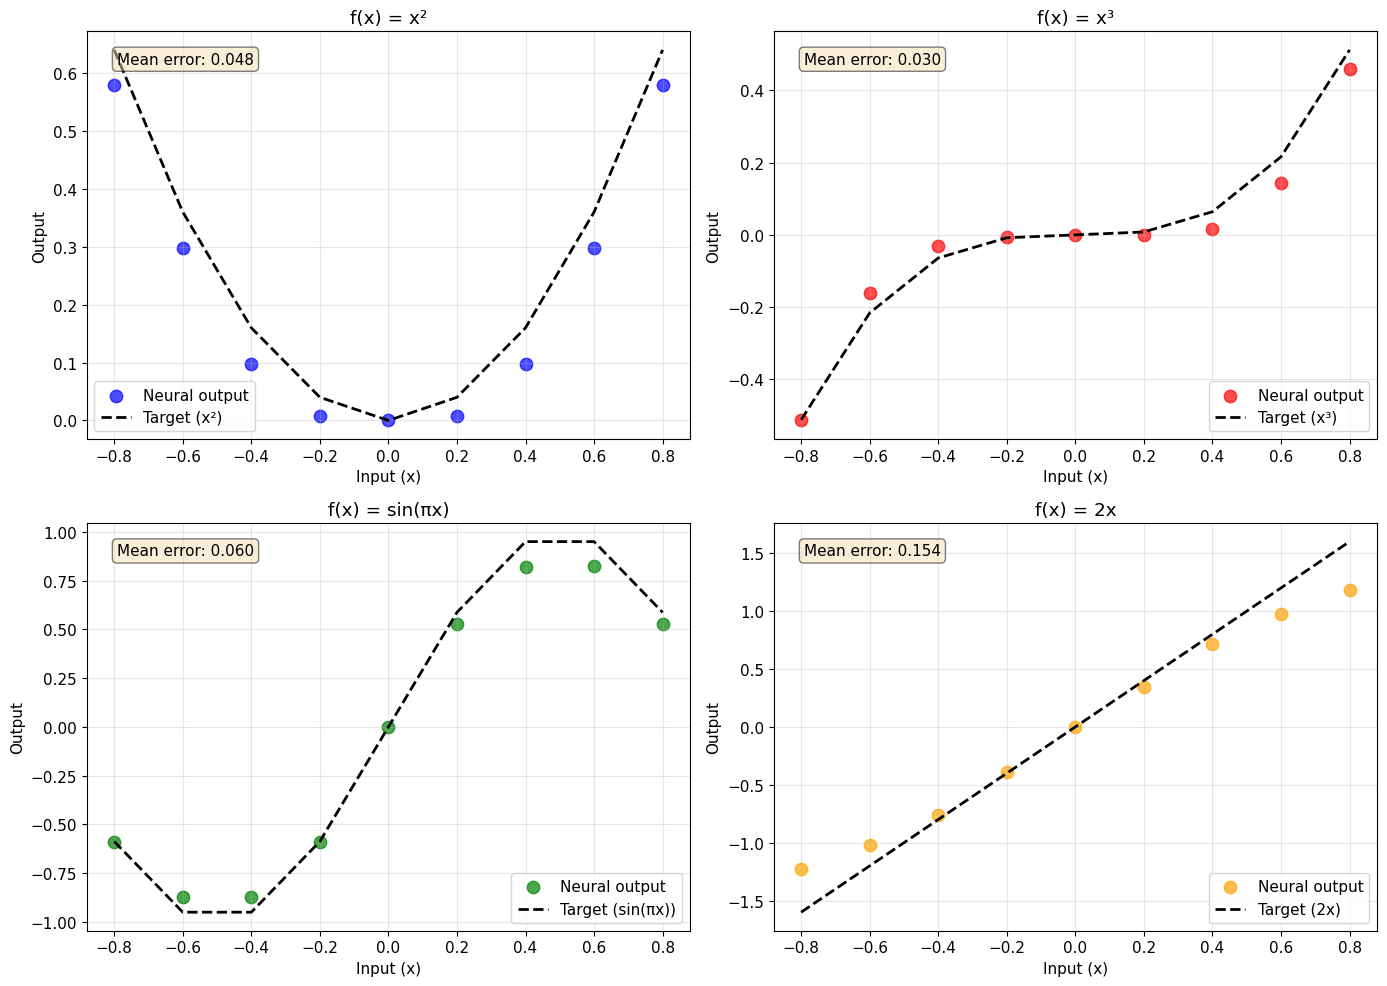

In [6]:
# Define different functions to test
functions = [
    (lambda x: x**2, 'x²', 'blue'),
    (lambda x: x**3, 'x³', 'red'),
    (lambda x: np.sin(np.pi * x), 'sin(πx)', 'green'),
    (lambda x: 2*x, '2x', 'orange'),
]

test_inputs = np.linspace(-0.8, 0.8, 9)

plt.figure(figsize=(14, 10))

for idx, (func, name, color) in enumerate(functions, 1):
    results = []
    
    for val in test_inputs:
        # Create ensembles
        ens_a = Ensemble(n_neurons=300, dimensions=1, seed=42)
        ens_b = Ensemble(n_neurons=300, dimensions=1, seed=43)
        ens_b.compute_decoders(n_samples=1000, noise_sigma=0.05)
        
        # Network
        net = Network(dt=0.001)
        net.add_ensemble(ens_a)
        net.add_ensemble(ens_b)
        conn = Connection(ens_a, ens_b, function=func)
        net.add_connection(conn)
        net.probe(ens_b, 'output', 'decoded')
        
        # Run
        ens_a.set_input(np.array([val]))
        net.run(duration=0.8)
        
        # Get result
        data = net.get_probe_data('output')
        output = data[-100:].mean()
        target = func(val)
        results.append((val, output, target))
    
    # Plot
    plt.subplot(2, 2, idx)
    inputs = [r[0] for r in results]
    outputs = [r[1] for r in results]
    targets = [r[2] for r in results]
    
    plt.scatter(inputs, outputs, label='Neural output', s=80, alpha=0.7, color=color)
    plt.plot(inputs, targets, '--', label=f'Target ({name})', linewidth=2, color='black')
    plt.xlabel('Input (x)')
    plt.ylabel('Output')
    plt.title(f'f(x) = {name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Print error
    errors = [abs(r[1] - r[2]) for r in results]
    plt.text(0.05, 0.95, f'Mean error: {np.mean(errors):.3f}', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Neural Multiplication

## Compute multiplication using a 2D ensemble: (x, y) -> x * y

Input: ( 0.50,  0.50), Output:  0.170, Target:  0.250, Error: 0.080
Input: ( 0.80,  0.30), Output:  0.167, Target:  0.240, Error: 0.073
Input: (-0.50,  0.60), Output: -0.258, Target: -0.300, Error: 0.042
Input: (-0.70, -0.40), Output:  0.197, Target:  0.280, Error: 0.083
Input: ( 0.90,  0.20), Output:  0.119, Target:  0.180, Error: 0.061
Input: (-0.30, -0.80), Output:  0.165, Target:  0.240, Error: 0.075


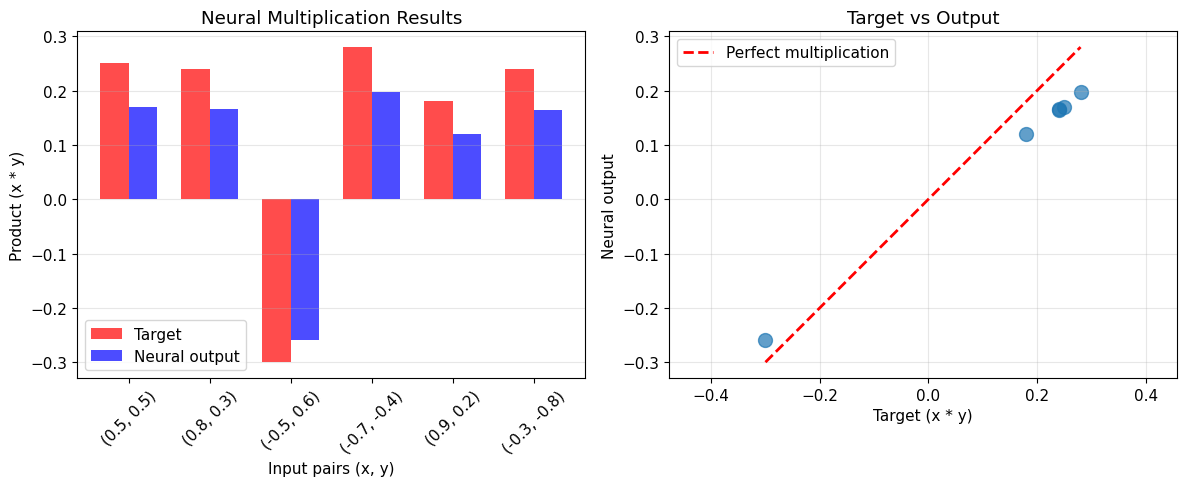


Mean error: 0.069
Max error: 0.083
RMSE: 0.070


In [7]:
# Parameters
N_NEURONS_2D = 600
N_NEURONS_1D = 300

# Test pairs
test_pairs = [
    (0.5, 0.5),
    (0.8, 0.3),
    (-0.5, 0.6),
    (-0.7, -0.4),
    (0.9, 0.2),
    (-0.3, -0.8),
]

results = []

for x, y in test_pairs:
    # Create ensembles
    ens_product = Ensemble(n_neurons=N_NEURONS_2D, dimensions=2, seed=42)
    ens_result = Ensemble(n_neurons=N_NEURONS_1D, dimensions=1, seed=43)
    ens_result.compute_decoders(n_samples=1000, noise_sigma=0.05)
    
    # Network
    net = Network(dt=0.001)
    net.add_ensemble(ens_product)
    net.add_ensemble(ens_result)
    
    # Connect with multiplication
    conn = Connection(ens_product, ens_result, 
                     function=lambda x: np.array([x[0] * x[1]]))
    net.add_connection(conn)
    
    # Probe
    net.probe(ens_result, 'output', 'decoded')
    
    # Set input and run
    ens_product.set_input(np.array([x, y]))
    net.run(duration=1.0)
    
    # Get output
    data = net.get_probe_data('output')
    final_output = data[-100:].mean()
    target = x * y
    
    results.append((x, y, final_output, target))
    print(f"Input: ({x:5.2f}, {y:5.2f}), Output: {final_output:6.3f}, Target: {target:6.3f}, Error: {abs(final_output - target):.3f}")

# Visualization
plt.figure(figsize=(12, 5))

# Bar plot comparison
plt.subplot(1, 2, 1)
x_pos = np.arange(len(results))
outputs = [r[2] for r in results]
targets = [r[3] for r in results]
labels = [f"({r[0]:.1f}, {r[1]:.1f})" for r in results]

width = 0.35
plt.bar(x_pos - width/2, targets, width, label='Target', alpha=0.7, color='red')
plt.bar(x_pos + width/2, outputs, width, label='Neural output', alpha=0.7, color='blue')
plt.xlabel('Input pairs (x, y)')
plt.ylabel('Product (x * y)')
plt.title('Neural Multiplication Results')
plt.xticks(x_pos, labels, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(targets, outputs, s=100, alpha=0.7)
min_val = min(min(targets), min(outputs))
max_val = max(max(targets), max(outputs))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect multiplication')
plt.xlabel('Target (x * y)')
plt.ylabel('Neural output')
plt.title('Target vs Output')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()

# Error statistics
errors = [abs(r[2] - r[3]) for r in results]
print(f"\nMean error: {np.mean(errors):.3f}")
print(f"Max error: {np.max(errors):.3f}")
print(f"RMSE: {np.sqrt(np.mean(np.array(errors)**2)):.3f}")

## Visualize Multiplication Surface

Computing multiplication grid (this may take a minute)...
Progress: 14%
Progress: 29%
Progress: 43%
Progress: 57%
Progress: 71%
Progress: 86%
Progress: 100%


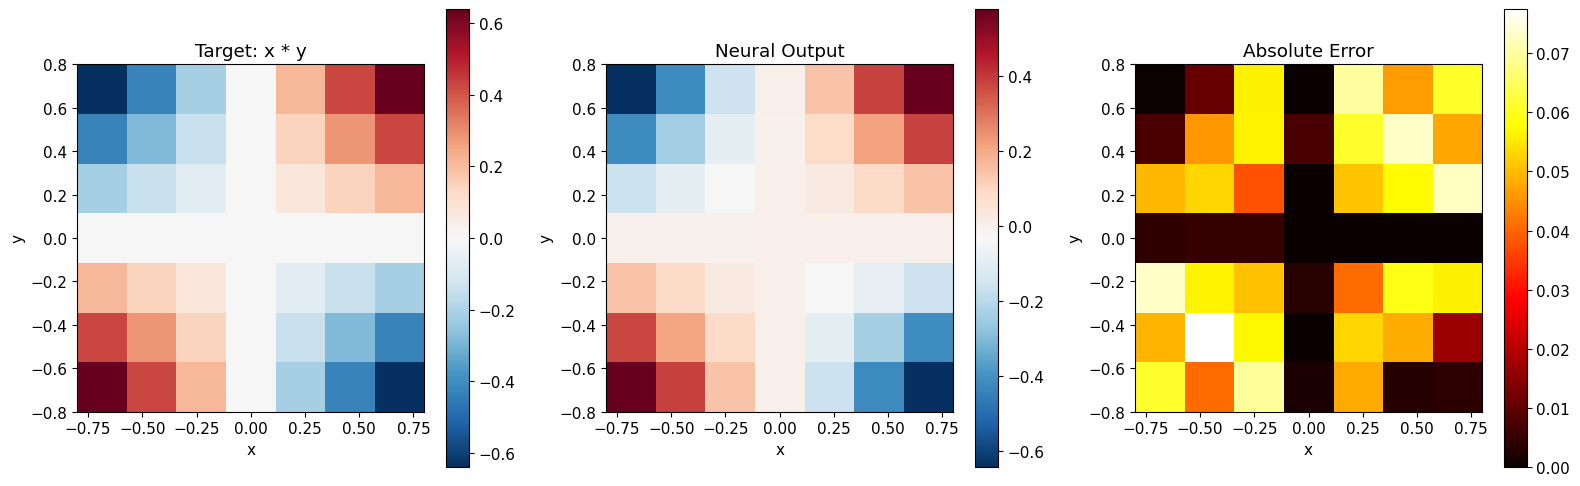


Mean error across grid: 0.036
Max error across grid: 0.077


In [8]:
# Create a grid of (x, y) values
x_vals = np.linspace(-0.8, 0.8, 7)
y_vals = np.linspace(-0.8, 0.8, 7)

results_grid = np.zeros((len(x_vals), len(y_vals)))
target_grid = np.zeros((len(x_vals), len(y_vals)))

print("Computing multiplication grid")
for i, x in enumerate(x_vals):
    for j, y in enumerate(y_vals):
        # Create ensembles
        ens_product = Ensemble(n_neurons=600, dimensions=2, seed=42)
        ens_result = Ensemble(n_neurons=300, dimensions=1, seed=43)
        ens_result.compute_decoders(n_samples=1000, noise_sigma=0.05)
        
        # Network
        net = Network(dt=0.001)
        net.add_ensemble(ens_product)
        net.add_ensemble(ens_result)
        conn = Connection(ens_product, ens_result, 
                         function=lambda x: np.array([x[0] * x[1]]))
        net.add_connection(conn)
        net.probe(ens_result, 'output', 'decoded')
        
        # Run
        ens_product.set_input(np.array([x, y]))
        net.run(duration=0.5)
        
        # Store result
        data = net.get_probe_data('output')
        results_grid[i, j] = data[-100:].mean()
        target_grid[i, j] = x * y
        
    print(f"Progress: {100*(i+1)/len(x_vals):.0f}%")

# Plot heatmaps
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Target
im1 = axes[0].imshow(target_grid.T, origin='lower', cmap='RdBu_r', 
                     extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]])
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Target: x * y')
plt.colorbar(im1, ax=axes[0])

# Neural output
im2 = axes[1].imshow(results_grid.T, origin='lower', cmap='RdBu_r',
                     extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]])
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Neural Output')
plt.colorbar(im2, ax=axes[1])

# Error
error_grid = np.abs(results_grid - target_grid)
im3 = axes[2].imshow(error_grid.T, origin='lower', cmap='hot',
                     extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]])
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].set_title('Absolute Error')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"\nMean error across grid: {error_grid.mean():.3f}")
print(f"Max error across grid: {error_grid.max():.3f}")

# Other Tests

## Neural Dynamics over Time

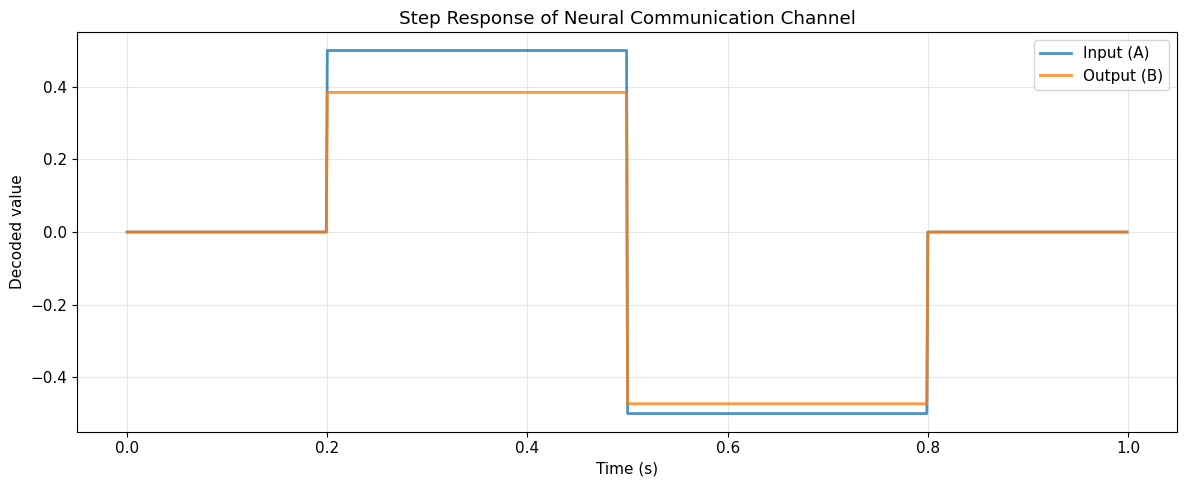

In [9]:
# Create a time-varying input signal
def time_varying_input_demo():
    """
    Demonstrate neural ensemble tracking a time-varying signal.
    Note: This requires modifying the network to accept time-varying inputs.
    For now, we'll show step responses.
    """
    # Test step response
    ens_a = Ensemble(n_neurons=200, dimensions=1, seed=42)
    ens_b = Ensemble(n_neurons=200, dimensions=1, seed=43)
    ens_b.compute_decoders(n_samples=1000, noise_sigma=0.05)
    
    net = Network(dt=0.001)
    net.add_ensemble(ens_a)
    net.add_ensemble(ens_b)
    conn = Connection(ens_a, ens_b)
    net.add_connection(conn)
    ens_a.compute_decoders(n_samples=1000, noise_sigma=0.05)
    
    net.probe(ens_a, 'input', 'decoded')
    net.probe(ens_b, 'output', 'decoded')
    
    # Start with zero
    ens_a.set_input(np.array([0.0]))
    net.run(duration=0.2)
    
    # Step to 0.5
    ens_a.set_input(np.array([0.5]))
    net.run(duration=0.3)
    
    # Step to -0.5
    ens_a.set_input(np.array([-0.5]))
    net.run(duration=0.3)
    
    # Step back to 0
    ens_a.set_input(np.array([0.0]))
    net.run(duration=0.2)
    
    # Plot
    data_a = net.get_probe_data('input')
    data_b = net.get_probe_data('output')
    times = np.arange(len(data_a)) * net.dt
    
    plt.figure(figsize=(12, 5))
    plt.plot(times, data_a, label='Input (A)', linewidth=2, alpha=0.8)
    plt.plot(times, data_b, label='Output (B)', linewidth=2, alpha=0.8)
    plt.xlabel('Time (s)')
    plt.ylabel('Decoded value')
    plt.title('Step Response of Neural Communication Channel')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

time_varying_input_demo()

## Neural Activities

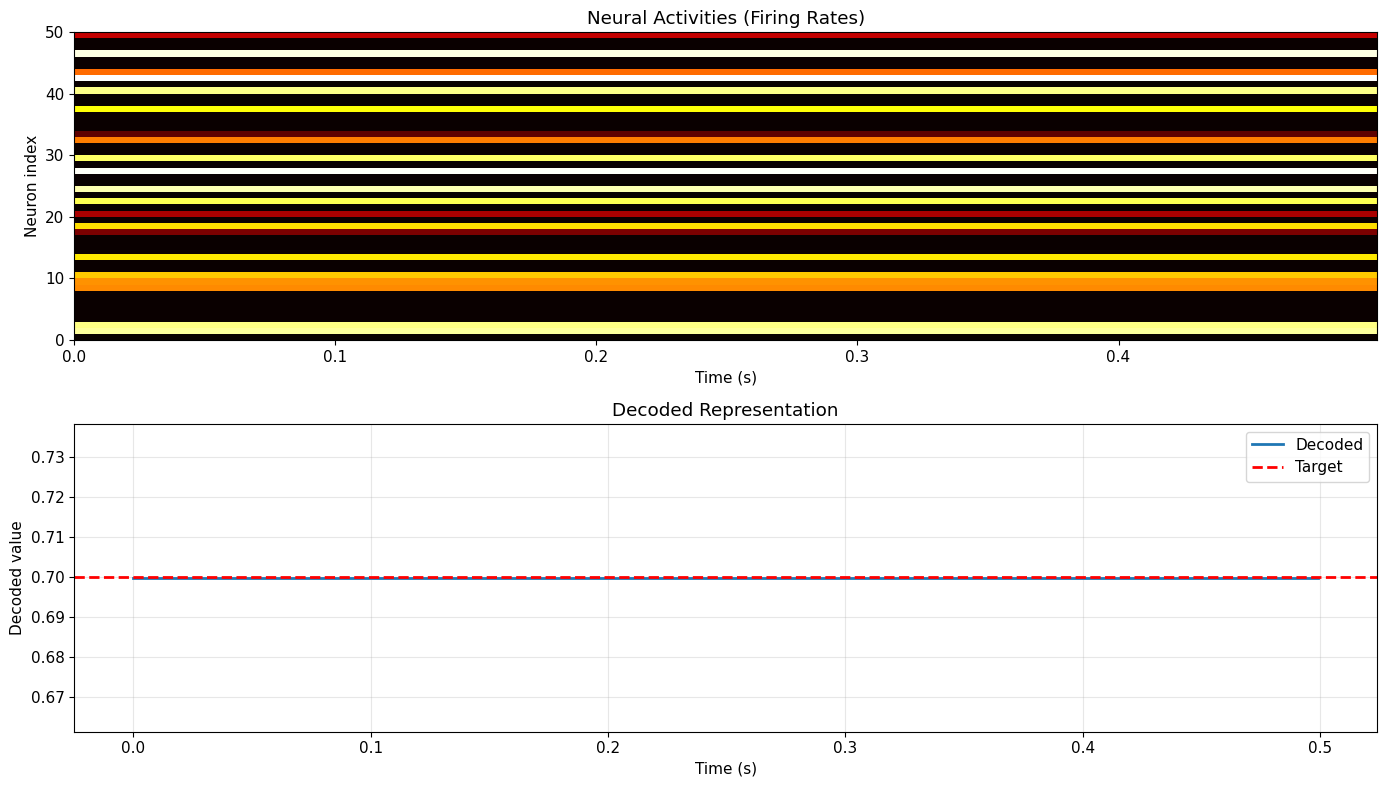

In [10]:
# Look at individual neuron activities
ens = Ensemble(n_neurons=50, dimensions=1, seed=42)
ens.compute_decoders(n_samples=1000, noise_sigma=0.05)

net = Network(dt=0.001)
net.add_ensemble(ens)
net.probe(ens, 'activities', 'activities')
net.probe(ens, 'decoded', 'decoded')

# Set input
input_val = 0.7
ens.set_input(np.array([input_val]))
net.run(duration=0.5)

# Get data
activities = net.get_probe_data('activities')
decoded = net.get_probe_data('decoded')
times = np.arange(len(decoded)) * net.dt

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Raster plot
axes[0].imshow(activities.T, aspect='auto', cmap='hot', 
               extent=[0, times[-1], 0, ens.n_neurons],
               interpolation='nearest')
axes[0].set_ylabel('Neuron index')
axes[0].set_title('Neural Activities (Firing Rates)')
axes[0].set_xlabel('Time (s)')

# Decoded value
axes[1].plot(times, decoded, linewidth=2, label='Decoded')
axes[1].axhline(input_val, color='r', linestyle='--', label='Target', linewidth=2)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Decoded value')
axes[1].set_title('Decoded Representation')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Parameter Sensitivity

Testing different neuron counts...
N= 50: Error = 0.3256
N=100: Error = 0.4464
N=150: Error = 0.0951
N=200: Error = 0.1156
N=250: Error = 0.0323
N=300: Error = 0.0517
N=400: Error = 0.0274
N=500: Error = 0.0873


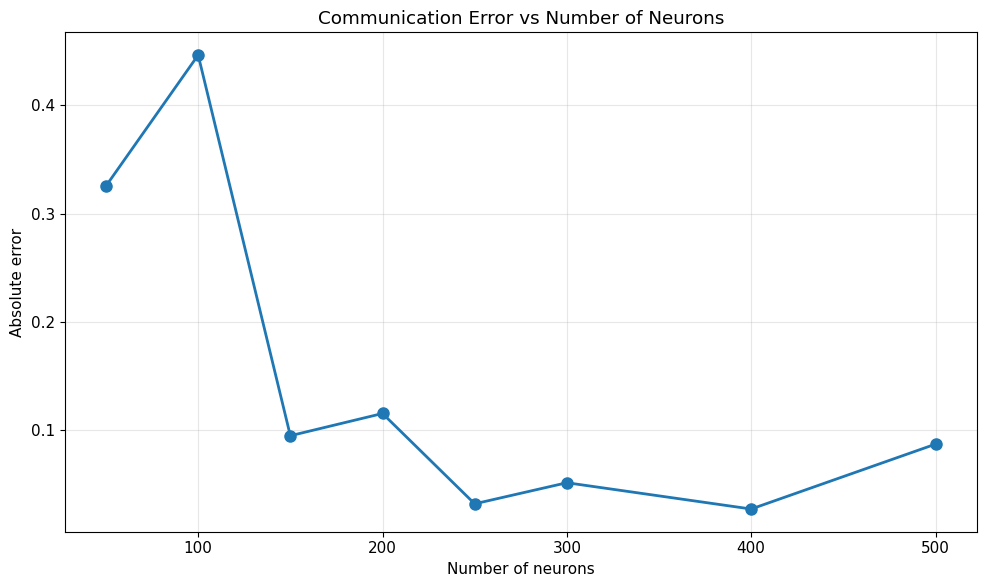

In [11]:
# Test how performance varies with number of neurons
neuron_counts = [50, 100, 150, 200, 250, 300, 400, 500]
test_input = 0.5
errors_by_neurons = []

print("Testing different neuron counts...")
for n_neurons in neuron_counts:
    ens_a = Ensemble(n_neurons=n_neurons, dimensions=1, seed=42)
    ens_b = Ensemble(n_neurons=n_neurons, dimensions=1, seed=43)
    ens_b.compute_decoders(n_samples=1000, noise_sigma=0.05)
    
    net = Network(dt=0.001)
    net.add_ensemble(ens_a)
    net.add_ensemble(ens_b)
    conn = Connection(ens_a, ens_b)
    net.add_connection(conn)
    net.probe(ens_b, 'output', 'decoded')
    
    ens_a.set_input(np.array([test_input]))
    net.run(duration=0.5)
    
    data = net.get_probe_data('output')
    output = data[-100:].mean()
    error = abs(output - test_input)
    errors_by_neurons.append(error)
    print(f"N={n_neurons:3d}: Error = {error:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(neuron_counts, errors_by_neurons, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of neurons')
plt.ylabel('Absolute error')
plt.title('Communication Error vs Number of Neurons')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()